In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Cargando dataset

In [118]:
# Lista de los valores únicos

df=pd.read_csv("../data/interim/modelado_FINAL.csv")

df.columns

Index(['id', 'title', 'location_area', 'company_display_name', 'contract_time',
       'salary_min', 'salary_max', 'salary_is_predicted', 'created',
       'latitude', 'longitude', 'redirect_url', 'description_full', 'remote',
       'permanent_contract', 'freelance', 'bonuses', 'career_development',
       'immediate_start', 'startup', 'multinational',
       'consulting_or_outsourcing', 'experience_gt_5', 'intern', 'junior',
       'senior', 'lead', 'principal_or_manager', 'higher_education',
       'certifications_required', 'software_development', 'data_science_ml',
       'cybersecurity', 'qa_testing', 'it_support_infrastructure',
       'project_product_management', 'ux_ui_design'],
      dtype='object')

In [ ]:
df

### Eliminar información muy irrelevante

En este caso borramos la columna de si el salario es una predicción de la plataforma de la que obtenemos los salarios

In [112]:
columns_to_drop = ['salary_is_predicted']
df = df.drop(columns=columns_to_drop)

Borramos ofertas cuyo título desvirtúa el dataset

In [136]:
# Lista de patrones que indican que NO es una oferta real de empleo
exclusion_keywords = [
    "paid market research",
    "research study",
    "study for",
    "60min",
    "participate in",
    "compensated interview",
    "survey study",
    "market research session"
]

# Convertir el título a minúsculas para asegurar coincidencias
df["title_clean"] = df["title"].fillna("").str.lower()

# Crear una máscara para detectar si alguna de esas frases aparece en el título
pattern = '|'.join(exclusion_keywords)
mask_fake_offers = df["title_clean"].str.contains(pattern, regex=True)

# Eliminar esas filas
df = df[~mask_fake_offers].copy()

# Limpiar la columna auxiliar si no la necesitas
df.drop(columns=["title_clean"], inplace=True)


In [137]:
df.shape

(74126, 40)

## Obtención de seniorities del título del trabajo
Para complementar el modelo zero-shot aplicado y conseguir mejores resultados

In [138]:
# Paso 1: Definir patrones regex por nivel de seniority (con prioridad)
seniority_regex = [
    ("cto", r"\b(?:cto|chief technology officer)\b"),
    ("principal_or_manager", r"\b(?:principal|manager)\b"),
    ("lead", r"\blead\b"),
    ("senior", r"\b(?:senior|sr)\b"),
    ("junior", r"\b(?:junior|jr)\b"),
    ("intern", r"\b(?:intern|trainee|internship|apprentice)\b")
]

# Paso 2: Asegurar que 'title' esté en minúsculas y sin NaNs
df["title"] = df["title"].fillna("").str.lower()

# Paso 3: Crear columnas auxiliares *_title para detección con regex
for level, pattern in seniority_regex:
    df[level + "_title"] = df["title"].str.contains(pattern, regex=True, na=False).astype(int)

# Paso 4: Asegurar que las columnas reales existen (crear 'cto' si hace falta)
for level, _ in seniority_regex:
    if level not in df.columns:
        df[level] = 0

# Paso 5: Si *_title es 1, sustituir la columna real por 1
for level, _ in seniority_regex:
    df.loc[df[level + "_title"] == 1, level] = 1

# Paso 6: Eliminar las columnas *_title
df.drop(columns=[level + "_title" for level, _ in seniority_regex], inplace=True)

# Paso 7: Crear la columna 'seniority' según prioridad
df['seniority'] = 'unknown'
for level, _ in seniority_regex:
    df.loc[(df[level] == 1) & (df['seniority'] == 'unknown'), 'seniority'] = level



In [139]:
columns_to_drop = ["cto"]
df.drop(columns=columns_to_drop)

,id,title,location_area,company_display_name,contract_time,salary_min,salary_max,salary_is_predicted,created,latitude,...,certifications_required,software_development,data_science_ml,cybersecurity,qa_testing,it_support_infrastructure,project_product_management,ux_ui_design,seniority,salary_avg
0,5172667476,it infrastructure administrator,"US, Ohio, Franklin County, Grandview Heights",Experis,NaN,92562.85,92562.85,1,2025-05-01T06:17:44Z,39.991073,...,0.353574,0.513744,0.176900,0.197202,0.227965,0.310890,0.820510,0.404728,unknown,92562.85
1,5043698107,it program manager,"US, Massachusetts, Middlesex County, Marlborough",BJ's Wholesale Club,NaN,106284.47,106284.47,1,2025-02-09T06:17:30Z,42.346740,...,0.504661,0.276124,0.329195,0.045312,0.022307,0.027231,0.378242,0.081963,principal_or_manager,106284.47
2,5172667443,it operations window engineer,"US, New York, Orange County, Chester",Experis,full_time,107743.86,107743.86,1,2025-05-01T06:17:44Z,41.353013,...,0.796602,0.633942,0.427687,0.490027,0.857570,0.436988,0.556164,0.473490,unknown,107743.86
3,5172673565,senior it business systems analyst,"US, Wisconsin, Kenosha County, Trevor","Uline, Inc.",full_time,118673.77,118673.77,1,2025-05-01T06:19:53Z,42.516405,...,0.659511,0.807941,0.362978,0.142299,0.338205,0.247681,0.854075,0.280981,senior,118673.77
4,5172673330,senior it business systems analyst,"US, Wisconsin, Racine County, Burlington","Uline, Inc.",full_time,112896.08,112896.08,1,2025-05-01T06:19:49Z,42.662802,...,0.767332,0.839628,0.171539,0.031274,0.057170,0.125325,0.546452,0.247142,senior,112896.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75005,5152643894,software engineer iii,"US, Ohio, Greene County, Riverside",Voyager Space Holdings,full_time,109000.00,130000.00,0,2025-04-18T23:48:08Z,39.763933,...,0.765566,0.977161,0.395482,0.448740,0.150237,0.201217,0.646336,0.234824,unknown,119500.00
75006,5168157112,cyber analyst - threat intelligence,"US, Ohio, Auglaize County, New Bremen",Crown Equipment Corporation,NaN,100280.55,100280.55,1,2025-04-29T03:51:05Z,40.436992,...,0.568216,0.211755,0.284250,0.635303,0.102045,0.234250,0.487559,0.122390,unknown,100280.55
75007,5046610235,"pharma & life sciences veeva team, senior manager","US, Ohio, Cuyahoga County, Newburgh Heights",PwC,NaN,136017.45,136017.45,1,2025-02-11T18:53:42Z,41.493070,...,0.969423,0.941225,0.883411,0.873030,0.954993,0.935115,0.961505,0.950420,principal_or_manager,136017.45
75008,5147030478,documentum developer,"US, Ohio, Franklin County, Columbus",FlightSafety International,NaN,101160.50,101160.50,1,2025-04-16T04:42:43Z,40.103832,...,0.839380,0.825707,0.362999,0.167612,0.400507,0.448072,0.822380,0.317238,unknown,101160.50


## Creando la columna "salary_avg"

Se eliminan los salarios con datos muy bajos que pueden distorsionar la media

In [140]:
df = df.drop(df[(df["salary_min"] <= 10000) | (df["salary_max"] <= 10000)].index)

In [141]:
# Crear la columna salary_avg como media de salary_min y salary_max
df["salary_avg"] = df[["salary_min", "salary_max"]].mean(axis=1)


## Limpiando seniorities y reduciendo columnas

### Obtención de media salarial de cada seniority

In [142]:
salary_by_seniority = (
    df[df['seniority'] != 'unknown']
    .groupby('seniority')['salary_avg']
    .median()
    .to_dict()
)
salary_by_seniority

{'cto': 121482.24,
 'intern': 55893.42,
 'junior': 72500.0,
 'lead': 118828.235,
 'principal_or_manager': 130999.795,
 'senior': 122089.845}

In [149]:
df

,id,title,location_area,company_display_name,contract_time,salary_min,salary_max,salary_is_predicted,created,latitude,...,software_development,data_science_ml,cybersecurity,qa_testing,it_support_infrastructure,project_product_management,ux_ui_design,cto,seniority,salary_avg
0,5172667476,it infrastructure administrator,"US, Ohio, Franklin County, Grandview Heights",Experis,NaN,92562.85,92562.85,1,1970,39.991073,...,0.513744,0.176900,0.197202,0.227965,0.310890,0.820510,0.404728,0,unknown,92562.85
1,5043698107,it program manager,"US, Massachusetts, Middlesex County, Marlborough",BJ's Wholesale Club,NaN,106284.47,106284.47,1,1970,42.346740,...,0.276124,0.329195,0.045312,0.022307,0.027231,0.378242,0.081963,0,principal_or_manager,106284.47
2,5172667443,it operations window engineer,"US, New York, Orange County, Chester",Experis,full_time,107743.86,107743.86,1,1970,41.353013,...,0.633942,0.427687,0.490027,0.857570,0.436988,0.556164,0.473490,0,unknown,107743.86
3,5172673565,senior it business systems analyst,"US, Wisconsin, Kenosha County, Trevor","Uline, Inc.",full_time,118673.77,118673.77,1,1970,42.516405,...,0.807941,0.362978,0.142299,0.338205,0.247681,0.854075,0.280981,0,senior,118673.77
4,5172673330,senior it business systems analyst,"US, Wisconsin, Racine County, Burlington","Uline, Inc.",full_time,112896.08,112896.08,1,1970,42.662802,...,0.839628,0.171539,0.031274,0.057170,0.125325,0.546452,0.247142,0,senior,112896.08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75005,5152643894,software engineer iii,"US, Ohio, Greene County, Riverside",Voyager Space Holdings,full_time,109000.00,130000.00,0,1970,39.763933,...,0.977161,0.395482,0.448740,0.150237,0.201217,0.646336,0.234824,0,unknown,119500.00
75006,5168157112,cyber analyst - threat intelligence,"US, Ohio, Auglaize County, New Bremen",Crown Equipment Corporation,NaN,100280.55,100280.55,1,1970,40.436992,...,0.211755,0.284250,0.635303,0.102045,0.234250,0.487559,0.122390,0,unknown,100280.55
75007,5046610235,"pharma & life sciences veeva team, senior manager","US, Ohio, Cuyahoga County, Newburgh Heights",PwC,NaN,136017.45,136017.45,1,1970,41.493070,...,0.941225,0.883411,0.873030,0.954993,0.935115,0.961505,0.950420,0,principal_or_manager,136017.45
75008,5147030478,documentum developer,"US, Ohio, Franklin County, Columbus",FlightSafety International,NaN,101160.50,101160.50,1,1970,40.103832,...,0.825707,0.362999,0.167612,0.400507,0.448072,0.822380,0.317238,0,unknown,101160.50


In [ ]:
# Columnas relacionadas con seniority (scores y títulos)
seniority_levels = ["intern", "junior", "senior", "lead", "principal_or_manager"]

title_columns = [f"{level}_title" for level in seniority_levels] + ["cto_title"]


# Calcular la media de salary_avg por cada nivel de seniority, cuando ese nivel es el dominante
salary_avg_means = {}
for level in seniority_levels:
    # Selecciona filas donde ese nivel es el dominante (valor más alto)
    is_dominant = df[level] >= df[[lvl for lvl in seniority_levels if lvl != level]].max(axis=1)
    salary_avg_means[level] = df[is_dominant]["salary_avg"].mean()

# Mapeo de jerarquía
seniority_ranks = {level: i for i, level in enumerate(seniority_levels)}

# Función para determinar el seniority
def determine_seniority(row):
    # Paso extra: detectar CTO por título
    if "cto_title" in row and row["cto_title"] == 1:
        return "cto"

    # 1. Revisar títulos presentes
    titles = {level: row.get(f"{level}_title", 0) for level in seniority_levels}
    active_titles = [level for level, val in titles.items() if val == 1]
    if active_titles:
        return max(active_titles, key=lambda x: seniority_ranks[x])
    
    # 2. Revisar scores
    scores = {level: row.get(level, 0) for level in seniority_levels}
    max_level = max(scores, key=scores.get)
    max_score = scores[max_level]
    second_max = max([v for k, v in scores.items() if k != max_level], default=0)

    # Si la diferencia es clara
    if max_score - second_max > 0.2:
        return max_level
    else:
        # 3. Comparar salary_avg con las medias por nivel
        if pd.isna(row["salary_avg"]):
            return max_level

        diffs = {
            level: abs(row["salary_avg"] - salary_avg_means[level])
            for level in seniority_levels
            if not pd.isna(salary_avg_means[level])
        }

        if not diffs:
            return max_level

        min_diff = min(diffs.values())
        closest_levels = [level for level, diff in diffs.items() if diff == min_diff]
        return max(closest_levels, key=lambda x: seniority_ranks[x])

# Aplicar la función al DataFrame
df["seniority"] = df.apply(determine_seniority, axis=1)


In [65]:
df.columns

Index(['id', 'title', 'location_area', 'company_display_name', 'contract_time',
       'salary_min', 'salary_max', 'created', 'latitude', 'longitude',
       'redirect_url', 'description_full', 'remote', 'permanent_contract',
       'freelance', 'bonuses', 'career_development', 'immediate_start',
       'startup', 'multinational', 'consulting_or_outsourcing',
       'experience_gt_5', 'higher_education', 'certifications_required',
       'software_development', 'data_science_ml', 'cybersecurity',
       'qa_testing', 'it_support_infrastructure', 'project_product_management',
       'ux_ui_design', 'salary_avg', 'seniority'],
      dtype='object')

## Dividiendo location_area

Dividimos el location area en `state`, `county` y `city`

In [66]:
df["location_area"]

0            US, Ohio, Franklin County, Grandview Heights
1        US, Massachusetts, Middlesex County, Marlborough
2                    US, New York, Orange County, Chester
3                   US, Wisconsin, Kenosha County, Trevor
4                US, Wisconsin, Racine County, Burlington
                               ...                       
75005                  US, Ohio, Greene County, Riverside
75006               US, Ohio, Auglaize County, New Bremen
75007         US, Ohio, Cuyahoga County, Newburgh Heights
75008                 US, Ohio, Franklin County, Columbus
75009             US, Ohio, Montgomery County, Miamisburg
Name: location_area, Length: 74779, dtype: object

In [67]:
# Eliminar 'US, ' de la columna location_area
df['location_area'] = df['location_area'].str.replace('US, ', '', regex=False)

# Dividir la columna location_area en partes, separadas por comas
split_location = df['location_area'].str.split(',', expand=True)

# Asegurarse de que las filas con menos de tres partes tengan valores NaN o None
split_location = split_location.rename(columns={0: 'state', 1: 'county', 2: 'city'})

# Limpiar los espacios en blanco en cada nueva columna
split_location['state'] = split_location['state'].str.strip()
split_location['county'] = split_location['county'].str.strip()
split_location['city'] = split_location['city'].str.strip()

# Reemplazar valores vacíos con None
split_location['state'] = split_location['state'].replace('', None)
split_location['county'] = split_location['county'].replace('', None)
split_location['city'] = split_location['city'].replace('', None)

# Unir las columnas resultantes de nuevo al dataframe original
df = df.join(split_location)



In [68]:
df = df.drop('location_area', axis=1)

In [69]:
df["state"] = df["state"].replace("US", np.nan)

## Aplicando thresholds
Con el fin de mejorar después las predicciones, establecemos unos límites a partir de los cuales una columna es "Sí" (1) o "No" (0)

In [70]:
df.describe()

,id,salary_min,salary_max,latitude,longitude,remote,permanent_contract,freelance,bonuses,career_development,...,higher_education,certifications_required,software_development,data_science_ml,cybersecurity,qa_testing,it_support_infrastructure,project_product_management,ux_ui_design,salary_avg
count,7.477900e+04,74764.00000,74570.000000,71181.000000,71181.000000,74779.000000,74779.000000,74779.000000,74779.000000,74779.000000,...,74779.000000,74779.000000,74779.000000,74779.000000,74779.000000,74779.000000,74779.000000,74779.000000,74779.000000,74764.00000
mean,5.096035e+09,111606.97560,116159.243352,37.550116,-92.892108,0.632876,0.650550,0.437754,0.716119,0.926109,...,0.581949,0.756953,0.638588,0.574533,0.557237,0.576854,0.672127,0.764181,0.580888,113874.73727
std,1.389843e+08,41078.35808,45704.086942,6.136171,18.016686,0.281703,0.270222,0.306773,0.212186,0.101590,...,0.267135,0.213128,0.287540,0.288565,0.305727,0.289410,0.262080,0.185999,0.326050,42532.94272
min,1.184900e+09,11700.00000,13000.000000,-14.273095,-170.703054,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12350.00000
25%,5.087133e+09,82990.29250,84969.740000,33.755711,-106.027500,0.395996,0.456272,0.135467,0.560741,0.913817,...,0.383901,0.637614,0.440095,0.323185,0.291155,0.332754,0.485995,0.645913,0.260574,84388.21000
50%,5.138850e+09,108801.82500,111278.890000,37.652379,-85.197741,0.702443,0.720992,0.424459,0.765740,0.964419,...,0.612659,0.822045,0.731261,0.651599,0.636541,0.649316,0.757283,0.815624,0.687995,110266.06500
75%,5.161752e+09,136287.56250,140505.055000,40.893946,-78.898800,0.881854,0.886772,0.715288,0.895249,0.987215,...,0.805767,0.930643,0.874773,0.825117,0.821682,0.827297,0.889526,0.917725,0.877352,138604.66250
max,5.174931e+09,450000.00000,600000.000000,71.300340,-66.567142,0.999899,0.999791,0.999674,0.999732,0.999954,...,0.999686,0.999776,0.999789,0.999635,0.999596,0.999718,0.999838,0.999763,0.999606,500000.00000


In [71]:
thresholds = {
    'remote': 0.8,
    'permanent_contract': 0.6,
    'freelance': 0.8,
    'bonuses': 0.5,
    'career_development': 0.6,
    'immediate_start': 0.7,
    'startup': 0.5,
    'multinational': 0.6,
    'consulting_or_outsourcing': 0.6,
    'experience_gt_5': 0.7,
    'higher_education': 0.7,
    'certifications_required': 0.7,
    'software_development': 0.6,
    'data_science_ml': 0.7,
    'cybersecurity': 0.6,
    'qa_testing': 0.5,
    'it_support_infrastructure': 0.6,
    'project_product_management': 0.7,
    'ux_ui_design': 0.6
}

In [72]:
# Lista de columnas
columns = list(thresholds.keys())

# Calcular la mediana de esas columnas
medianas = df[columns].median()
print(medianas)


remote                        0.702443
permanent_contract            0.720992
freelance                     0.424459
bonuses                       0.765740
career_development            0.964419
immediate_start               0.602028
startup                       0.553790
multinational                 0.733201
consulting_or_outsourcing     0.578220
experience_gt_5               0.724017
higher_education              0.612659
certifications_required       0.822045
software_development          0.731261
data_science_ml               0.651599
cybersecurity                 0.636541
qa_testing                    0.649316
it_support_infrastructure     0.757283
project_product_management    0.815624
ux_ui_design                  0.687995
dtype: float64


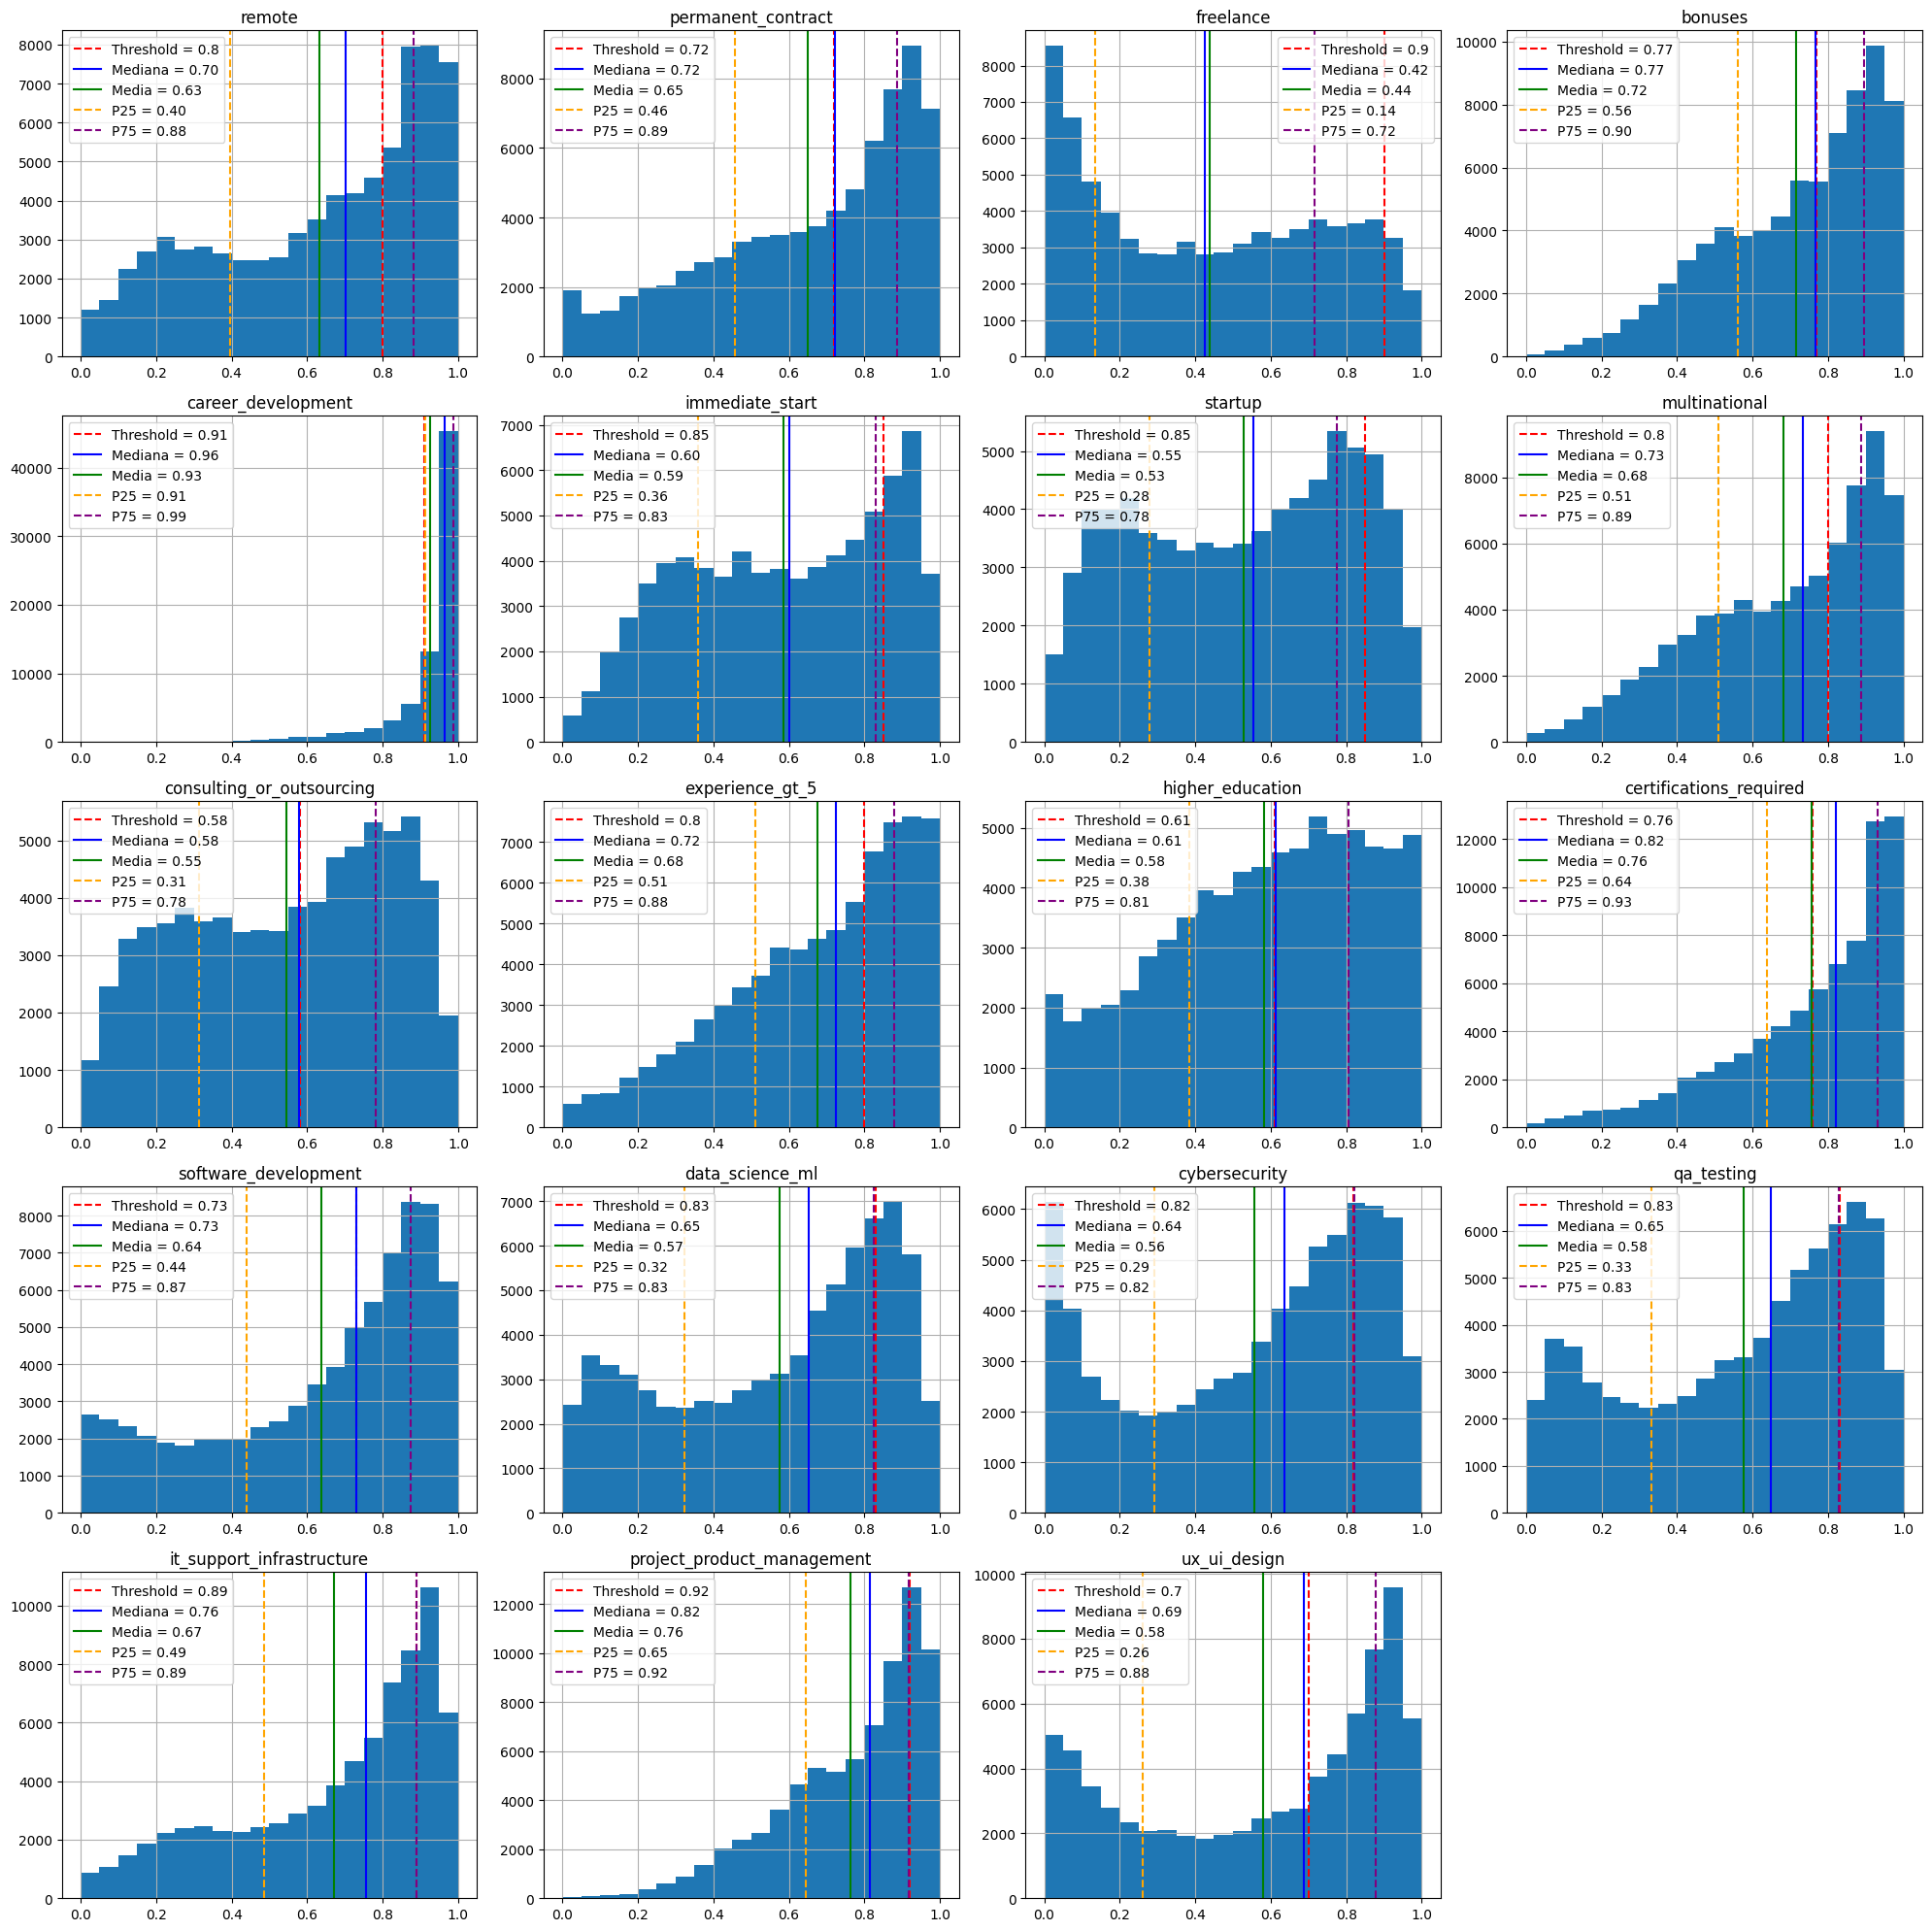

In [91]:
# Agregar líneas para media, percentil 25 y 75, además de mediana y threshold

fig, axes = plt.subplots(nrows=rows, ncols=cols_per_row, figsize=(20, rows * 4))
axes = axes.flatten()

for idx, (col, thr) in enumerate(thresholds.items()):
    ax = axes[idx]
    df[col].hist(ax=ax, bins=20)
    
    # Threshold
    ax.axvline(x=thr, color='red', linestyle='--', label=f'Threshold = {thr}')
    
    # Estadísticas
    median_val = df[col].median()
    mean_val = df[col].mean()
    q25 = df[col].quantile(0.25)
    q50 = df[col].quantile(0.50)
    q75 = df[col].quantile(0.75)
    

    ax.axvline(x=median_val, color='blue', linestyle='-', label=f'Mediana = {median_val:.2f}')
    ax.axvline(x=mean_val, color='green', linestyle='-', label=f'Media = {mean_val:.2f}')
    ax.axvline(x=q25, color='orange', linestyle='--', label=f'P25 = {q25:.2f}')
    ax.axvline(x=q75, color='purple', linestyle='--', label=f'P75 = {q75:.2f}')

    ax.set_title(col)
    ax.legend()

# Ocultar subplots vacíos
for i in range(idx + 1, len(axes)):
    axes[i].axis('off')

plt.tight_layout()
plt.show()




In [86]:
thresholds = {
    'remote': 0.8,
    'permanent_contract': 0.72,
    'freelance': 0.9,
    'bonuses': 0.77,
    'career_development': 0.91,
    'immediate_start': 0.85,
    'startup': 0.85,
    'multinational': 0.8,
    'consulting_or_outsourcing': 0.58,
    'experience_gt_5': 0.8,
    'higher_education': 0.61,
    'certifications_required': 0.76,
    'software_development': 0.73,
    'data_science_ml': 0.83,
    'cybersecurity': 0.82,
    'qa_testing': 0.83,
    'it_support_infrastructure': 0.89,
    'project_product_management': 0.92,
    'ux_ui_design': 0.7
}

In [87]:
df_binario = df.copy() 

for column in df.columns:
    threshold = thresholds.get(column, None)  # Obtener el umbral para cada columna
    if threshold is not None:
        df_binario[column] = (df[column] > threshold).astype(int)

In [ ]:
# Convertir la columna 'created' a tipo datetime
df_binario["created"] = pd.to_datetime(df_binario["created"])

# Extraer solo el año
df_binario["created"] = df_binario["created"].dt.year


In [89]:
df_binario.columns

Index([                        'id',                      'title',
             'company_display_name',              'contract_time',
                       'salary_min',                 'salary_max',
                          'created',                   'latitude',
                        'longitude',               'redirect_url',
                 'description_full',                     'remote',
               'permanent_contract',                  'freelance',
                          'bonuses',         'career_development',
                  'immediate_start',                    'startup',
                    'multinational',  'consulting_or_outsourcing',
                  'experience_gt_5',           'higher_education',
          'certifications_required',       'software_development',
                  'data_science_ml',              'cybersecurity',
                       'qa_testing',  'it_support_infrastructure',
       'project_product_management',               'ux_ui_desi

In [90]:
df_binario.to_csv('../data/interim/dataset_binario.csv', index=False)

In [148]:
df["created"].unique

<bound method Series.unique of 0        1970
1        1970
2        1970
3        1970
4        1970
         ... 
75005    1970
75006    1970
75007    1970
75008    1970
75009    1970
Name: created, Length: 74126, dtype: int32>